# MNIST Dataset

In [24]:
import torch   #general pytorch
import torch.nn as nn  #neural network module
import torch.nn.functional as F  #useful functions like softmax, or relu

#pip install torchvision; conda install torchvision
from torchvision import datasets, transforms  #transforms for image processing
from torch.utils.data import DataLoader       #dataloader for preparing batch

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## 1. ETL

In [2]:
#load the dataset
#DON'T FOLLOW MY ../data, put where you want.....

#train basically mean is this training set?
#download is download....
#transform means do you want to apply any processing to these images

#for the transform, we gonna just convert to tensor
transform = transforms.ToTensor()  #this NOT only converts to tensor, but also 
#converts from 0 to 255 to 0 to 1

train = datasets.MNIST(root="../data", train=True, download=True, transform = transform)

In [3]:
test = datasets.MNIST(root="../data", train=False, download=True, transform = transform)

In [4]:
#Examine 
type(train[0])  #tuple of (image, target)

tuple

In [5]:
# train[0]  #notice that all numbers are between 0 and 1, the second tuple is target
# image  = train[0][0]
# target = train[0][1]
image, target = train[0]
image.size()  #(1, 28, 28) = (channel, width, height)
target        #5

5

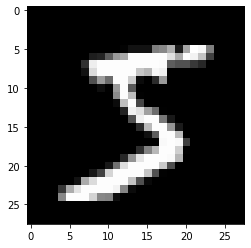

In [6]:
#image show, input format must be (w, h)
plt.imshow(image.reshape((28, 28)), cmap="gray")

In [7]:
image, target = train[1]
target

0

## 2. Setup the dataloader

`DataLoader` is for preparing a generator, that gonna output batch by batch.

In [8]:
#set the seed for reproducibility in shuffling
torch.manual_seed(999)   #why 999?

#set the dataloader
train_batch_size = 100  #how do i know 100?  because Chaky's PC
test_batch_size  = 10000
#format: DataLoader(dataset, batch_size, shuffle)
train_loader = DataLoader(train, batch_size = train_batch_size, shuffle=True)
test_loader  = DataLoader(test,  batch_size = test_batch_size, shuffle=True)

#Note:  In good practice, you MUST also have val_loader, but I am lazy today, because
#i want to keep things simple; I will show val_loader when we use CNN for MNIST....

In [9]:
#let's test the loader (because some of you are still confused....)
for images, targets in train_loader:
    print(images.shape)  #what is the shape?  (100, 1, 28, 28)
    print(targets.shape) #what is the shape?  (100)
    break
#remember that train_loader has a counter, so it will keep on running

torch.Size([100, 1, 28, 28])
torch.Size([100])


## 2. EDA

Labels:  [4 3 8 8 9 0 8 5 9 2 2 9]


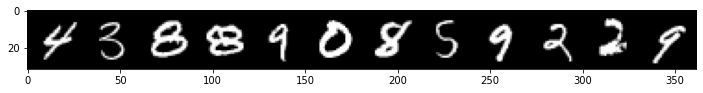

In [10]:
#so let's try to print out some images......in a grid form
from torchvision.utils import make_grid

#we already have 100 images, and 100 targets
print("Labels: ", targets[:12].numpy())

#plot the images....
im = make_grid(images[:12], nrow=12)   #default nrow is 8

#imshow takes either (W, H) or (W, H, C)
#our images are (C, W, H), so we need to change the position; using `tranpose()`
im_transpose = np.transpose(im, (1, 2, 0))  #why (1, 2, 0) because C now because the last guy
plt.figure(figsize=(12, 8))
plt.imshow(im_transpose)


## 3. Training

In [11]:
#please create a network using class format
#layer 1 = linear layer of shape (784, 89)
#layer 2 = relu  (use F.relu())
#layer 3 = linear layer of shape (89, 10)

class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()  #inherit everything from nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size)  #(784, 89)
        self.layer2 = nn.Linear(hidden_size, output_size) #(89, 10)
        self.relu   = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)  #after here, you DON'T have to softmax
                                #because pytorch cross entropy loss combines
                                #softmax + cross entropy
        
        return out
        

In [12]:
input_size  = 784
hidden_size = 89
output_size = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
model = NN(input_size, hidden_size, output_size).to(device)
model

NN(
  (layer1): Linear(in_features=784, out_features=89, bias=True)
  (layer2): Linear(in_features=89, out_features=10, bias=True)
  (relu): ReLU()
)

In [13]:
#count the parameters of the model
for p in model.parameters():
    print(p.shape)


torch.Size([89, 784])
torch.Size([89])
torch.Size([10, 89])
torch.Size([10])


In [14]:
#what is numel()???
sum(p.numel() for p in model.parameters() if p.requires_grad==True)
#where does this 70765 number comes from?

#89 * 784 + 89 + 10*89 + 10
#we want (1) least amount of parameters but (2) with highest accuracy

70765

In [15]:
#define the cross entropy loss
J_fn = nn.CrossEntropyLoss()  #combine softmax and cross entropy loss


In [16]:
#define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [18]:
#training
epochs = 5

#for epochs
for i in range(epochs):
    total_corr = 0
    acc = 0
    
    #for loader
    for batch, (images, targets) in enumerate(train_loader):

        #image reshape to (m, n)
        images  = images.reshape(-1, 28*28).to(device)  #(100, 784)
        targets = targets.to(device)                    #(100)
        #targets
        
        #1. predict
        yhat = model(images)  # (100, 10)
        #1.1 calculate the accuracy
        predicted = torch.max(yhat, 1)[1]   #if you use 0, it will return the probability, 1 is for index
        #predicted.shape (100)
        batch_corr = (predicted == targets).sum()
        total_corr += batch_corr
        
        #2. loss
        loss = J_fn(yhat, targets)
        #3. clear gradients using zero_grad()
        optimizer.zero_grad()
        #4. backprop using backward()
        loss.backward()
        #5. update using step()
        optimizer.step()
        
        if batch % 400 == 0:
            acc = (total_corr * 100) / (train_batch_size * (batch + 1))
            print(f"Epoch: {i:1.0f}: Batch: {batch:>3}; Loss: {loss:3.2f}; Acc: {acc:3.2f}")

Epoch: 0: Batch:   0; Loss: 2.28; Acc: 20.00
Epoch: 0: Batch: 400; Loss: 1.21; Acc: 59.61
Epoch: 1: Batch:   0; Loss: 0.79; Acc: 90.00
Epoch: 1: Batch: 400; Loss: 0.50; Acc: 84.80
Epoch: 2: Batch:   0; Loss: 0.62; Acc: 77.00
Epoch: 2: Batch: 400; Loss: 0.36; Acc: 87.61
Epoch: 3: Batch:   0; Loss: 0.38; Acc: 90.00
Epoch: 3: Batch: 400; Loss: 0.41; Acc: 88.81
Epoch: 4: Batch:   0; Loss: 0.41; Acc: 88.00
Epoch: 4: Batch: 400; Loss: 0.32; Acc: 89.48


## 4. Testing

In [19]:
with torch.no_grad():   #why no gradients during test; because we don't need backpropagation!
    correct = 0
    acc     = 0
    total   = 0
    
    for images, targets in test_loader:
        images  = images.reshape(-1, 28*28).to(device)  #(100, 784)
        targets = targets.to(device)                    #(100)
        
        #1. predict
        yhat    = model(images)
        #2. measure acc
        predicted = torch.max(yhat, 1)[1]   #if you use 0, it will return the probability, 1 is for index
        #predicted.shape (100)
        batch_corr = (predicted == targets).sum()
        correct   += batch_corr
        total     += targets.shape[0]
    
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}")
                

Accuracy: 90.35


## 5. Optional:  I want to know where are my errors (using confusion matrix)

In [20]:
yhat.shape

torch.Size([10000, 10])

In [21]:
targets.shape

torch.Size([10000])

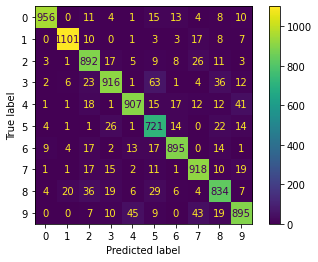

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix(predicted, targets))
disp.plot()